In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
import matplotlib.pyplot as plt

In [32]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50 

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("BeeImages", shuffle=True,image_size= (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE) 
#This loads all the files and images into the dataset variable

Found 7219 files belonging to 2 classes.


In [34]:
class_names = dataset.class_names
class_names

['Apis mellifera', 'Bombus Affinis']

In [35]:
len(dataset) # every element is a batch of 32 images

226

In [36]:
17495/32

546.71875

In [37]:
for image_batch, label_batch in dataset.take(1): # we are taking one batch from the dataset with the image and label batch
    print(image_batch.shape)
    print(label_batch.numpy()) 
    

# THE ARRAT REPRESENTS THE CLASSNAME IN THE CLASS NAME ARRAY    
# FOR EXAMPLE FIRST POS IN ARRAY IS 3 WICH MEANS THE FIRST IMAGE IN THE BATCH IS A BOBMUS BIMACULATUS

(32, 256, 256, 3)
[0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0]


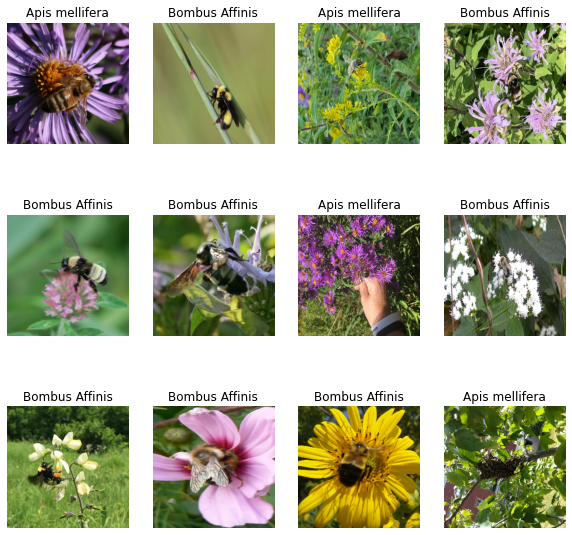

In [38]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [39]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,val_split=0.1, shuffle_size=10000, shuffle=True):
    
    ds_size =len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds, val_ds, test_ds
    
    
    

In [40]:
train_ds,val_ds,test_ds = get_dataset_partitions(dataset)

In [41]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # imporves performance on my computer 
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
resize_rescale = tf.keras.Sequential([ # this layer takes care of any images outside of the image size - resizes and rescales them
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255) # scales the images between 0 and 1
])

In [43]:
data_augmentation = tf.keras.Sequential([ # this layer varies the data for us
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [44]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [46]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
180/180 [==============================] - 557s 2s/step - loss: 0.8960 - accuracy: 0.6633 - val_loss: 0.5364 - val_accuracy: 0.7372
Epoch 2/50
180/180 [==============================] - 319s 2s/step - loss: 0.5221 - accuracy: 0.7461 - val_loss: 0.5782 - val_accuracy: 0.7088
Epoch 3/50
180/180 [==============================] - 329s 2s/step - loss: 0.4855 - accuracy: 0.7773 - val_loss: 0.4877 - val_accuracy: 0.7685
Epoch 4/50
180/180 [==============================] - 333s 2s/step - loss: 0.4505 - accuracy: 0.7987 - val_loss: 0.4603 - val_accuracy: 0.7798
Epoch 5/50
180/180 [==============================] - 318s 2s/step - loss: 0.4202 - accuracy: 0.8168 - val_loss: 0.5060 - val_accuracy: 0.7543
Epoch 6/50
180/180 [==============================] - 335s 2s/step - loss: 0.4167 - accuracy: 0.8149 - val_loss: 0.4316 - val_accuracy: 0.8139
Epoch 7/50
180/180 [==============================] - 332s 2s/step - loss: 0.4093 - accuracy: 0.8208 - val_loss: 0.4456 - val_accuracy: 0.8111

In [48]:
import numpy as np

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


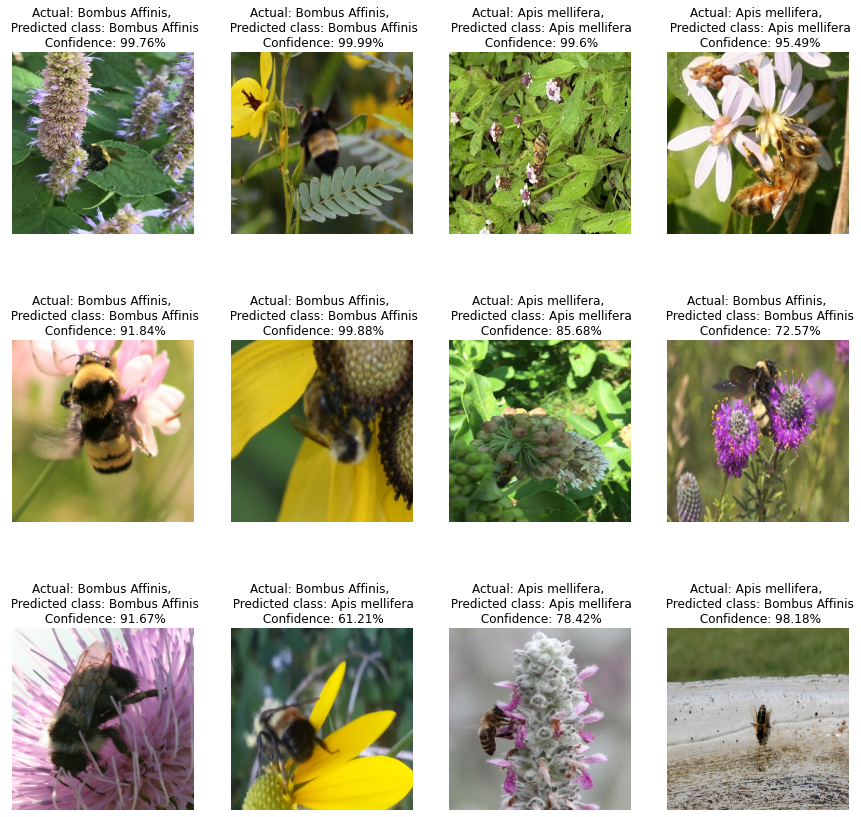

In [50]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test_ds.take(1):
    
    for i in range(12):
        
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]
        
        
        plt.title(f"Actual: {actual_class}, \n Predicted class: {predicted_class}\n Confidence: {confidence}%")
        
        plt.axis("off")

In [51]:
model_version = 'Honey_and_BumbleBees_V3'
model.save(f'C:\\Users\\jjoan\\Desktop\\BeeCode\\Models\\{model_version}')

model_h5 = 'Honey_and_BumbleBees_V3.h5'
model.save(f'C:\\Users\\jjoan\\Desktop\\BeeCode\\Models\\{model_h5}')

INFO:tensorflow:Assets written to: C:\Users\jjoan\Desktop\BeeCode\Models\Honey_and_BumbleBees_V3\assets


In [52]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 180}

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8960402607917786,
 0.5220781564712524,
 0.4854566752910614,
 0.45045432448387146,
 0.42017170786857605]

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

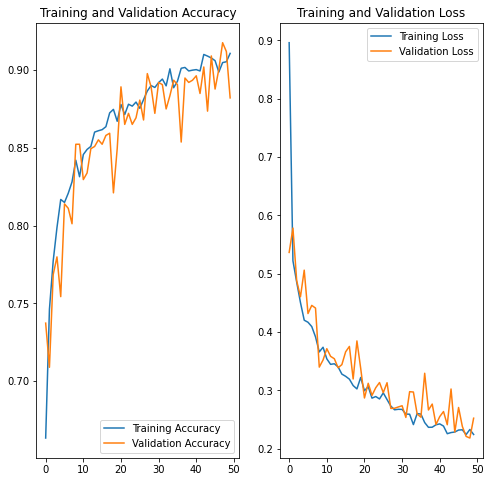

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()